# An Introduction to Python Packaging

## Basic concepts: files, scripts and modules

In our previous lecture about modularization, we already discussed the concept of modules and how to import them. A package is a collection of modules that we can now import together and document separately, and it builds on those previous concepts. We will briefly review the basics and move on to learning how to build a complete, standalone package.

To recap: A Python file, `file.py` is any file whose syntax is valid Python. Its contents can be executed in several different ways:

Direct execution
: We can call at the command line `python file.py` (or equivalently `./file.py` if the file is executable and has its "shebang" set to `#!/usr/bin/env python` or similar).  In this scenario, the file is being **executed** and the Python interpreter runs over the entire content of the file, redirecting `print()` calls to standard output/error.

: In this case, the Python interpreter sets a the variable `__name__` to the string `"__main__"`.

Importing
: If a Python process runs the statement `import file`, and `file.py` is found either in the current directory or in the paths specified in the environment variable `$PYTHONPATH`, then its contents are also executed, but with the the variable `__name__` to the string `"file"` (whatever the name of the file happens to be, minus the extension).

This simple trick of setting this global variable `__name__` to two different values depending on how the script is executed allows for a simple and elegant way to combine "executable script" and "reusable module" into a single Python file. In other programming languages, the distinction between building a "program" and a "library" requires more complex tooling.

Let's see a quick illustration by making a Python file:

In [1]:
%%writefile simple_name.py

print(f"In this file, {__name__=}")
print("This part is always run, regardless of how the file gets called.")

def f():
    print("f() says hello!")

if __name__ == "__main__":
    print("   *** The 'main script' part of this file is here! ***")

Overwriting simple_name.py


And first, calling it via the "direct execution" method:

In [22]:
!python simple_name.py

In this file, __name__='__main__'
This part is always run, regardless of how the file gets called.
   *** The 'main script' part of this file is here! ***


And we can compare that to what happens when we import the code (instead of importing it from another Python file, we can execute a single statement at the command line with the `-c` flag):

In [23]:
!python -c "import simple_name;simple_name.f()"

In this file, __name__='simple_name'
This part is always run, regardless of how the file gets called.
f() says hello!


With this simple example, we see how we can have in a given folder, python files that can serve both the role of working as scripts and as modules that expose functions for other scripts.

### Reminder: `%run` in IPython

The above are the mechanisms that plain Python exposes. As we have mentioned before, IPython offers in the `%run` magic the ability to run scripts, and in fact provides control over the value of `__name__` to provide convenience for several use cases. 

Observe the difference between the following ways of using `%run` with our `simple_file.py`:

In [24]:
%run simple_name

In this file, __name__='__main__'
This part is always run, regardless of how the file gets called.
   *** The 'main script' part of this file is here! ***


In [25]:
%run -n simple_name

In this file, __name__='simple_name'
This part is always run, regardless of how the file gets called.


In both cases, we now have access to `f()`, as `%run` loads all variables defined in the script into our kernel's namespace:

In [26]:
f()

f() says hello!


## The absolute minimal package

In Python, just like a simple `file.py` is enough to have a module you can import, the absolute bare minimum you need for a package is a folder that has a (can be empty!) file called `__init__.py` in it. Then, other files Python in that folder can be imported, and the folder is your package!

Let's make one of these:

In [44]:
%%bash
rm -rf minipak
mkdir -p minipak
touch minipak/__init__.py

In [45]:
%%writefile minipak/funcs.py
def add(a, b):
    return a+b

Writing minipak/funcs.py


We can see the folder `minipak` has only two files, one which is empty:

In [40]:
!ls -l minipak

total 4
-rw-r--r-- 1 jovyan jovyan 30 Oct 15 05:59 funcs.py
-rw-r--r-- 1 jovyan jovyan  0 Oct 15 05:59 __init__.py


But we can still import its `funcs` module, and call functions in it!

In [46]:
from minipak import funcs
funcs.add(2, 3)

5

## Learning with a small but more realistic package: `mytoy`

Now, we are going to transition from single modules that are mostly used locally (that is, defined in a single file next to the scripts that need them), to learning how to build a complete, modern Python package that can contain multiple modules, can be installed, tested, etc.  While the above example of sticking a couple of scripts in a folder and adding an empty `__init__.py` file works for the simplest of cases, and is a good starting point, we're now going to put a bit more structure. With just a few more things in place, we have enough scaffolding to go from simple but real-world cases, to arbitrarily large and complex packages of the size of xarray or pandas.

In this course, we will stop short of _publishing_ the package, but that's an easy step you can take later when you have a real package you wish to make available to others. The one we will use today is just a toy to illustrate the various moving parts.

We will work with the following minimal Python package, [mytoy](https://github.com/fperez/mytoy). You can clone this repository with:

```bash
git clone https://github.com/fperez/mytoy.git
```

This repository contains a minimal, toy Python package with a few files as illustration for students of how to lay out their code to meet minimal Python packaging requirements.

It has a single source directory (`mytoy`) with an `__init__.py` file and one "implementation" file (`toys.py`) as well as a few tests in `mytoy/tests`.

In addition to this `README.md` it includes some basic infrastructure: `LICENSE`, `pyproject.toml` and `.gitignore` files, as well as a `binder` folder that contains the necessary files for the above Binder link to work.

The only docs included are this `README.md` file - a larger package would have a proper docs directory and associated Sphinx/JupyterBook build.

This is more or less the absolute minimum for a "real" python package that can be installed from source, tested and experimented with on Binder.  For a more "official" version of this same idea, see the [PyPA sample project repo](https://github.com/pypa/sampleproject), documented in detail in the [Packaging Tutorial](https://packaging.python.org/en/latest/tutorials/packaging-projects). The [Python Packaging User Guide](https://packaging.python.org) contains comprehensive documentation on this topic.

Let's now disentangled some of the contents in `mytoy`. Let's begin with some simple example.  

### Import a package

Let's begin by creating a simple analysis notebook `Analysis.ipynb`. Inside the notebook we make an import of a new package called `mytoy` with the syntax:
```python
import mytoy
```
where in the same folder we have a folder called my toy with the following contents. You folder should like something like this:

The actual Python code is contained in the `.py` files, where we include some basic functions, classes and other objects we want to import. In order to the import to work, we need to create the index file `__init__.py` with the following contents:
```
"""
My Toy package
"""

__version__ = "0.0.1"

from .toys import *
```
The first part of the script is the docstring we already discussed in the lecture about documentation. The `__version__` variable follows the convention of specifying the version number with a sequence of three digits, labeled as major, minor and patch (more information about the convention of these three digits in the [Semantic Version documentation](https://semver.org)).

````{note}
In the case of being constantly making changes to your package code, you can include the `autoreload` command so the changes in the package are updated in the notebook without the need of restarting the kernel
```python
%load_ext autoreload
%autoreload 2
```
````

### Making a package installable

Now, in order to import `mytoy` we need to be in the folder where `mytoy` lives. However, we want `mytoy` to be available everywhere where Python is available, in the same way we can import `numpy` and `matplotlib` from every notebook and Python session. 

In order to make a package installable, we need to include a file inside `mytoy` named `pyproject.toml`. This file looks as follows, and we'll briefly explain its key parts (you can later read the documentation linked below for all the gory details):

```toml
[build-system]
requires = ["setuptools >= 70"]
build-backend = "setuptools.build_meta"

[project]
name = "mytoy"
authors = [
  { name="Example Author", email="author@example.com" },
]
description = "A Python library to make toys"
readme = "README.md"

requires-python = ">=3.10"
dependencies = [
    "tqdm",
]

license = "BSD-3-Clause"
license-files = ["LICEN[CS]E*"]
classifiers = [
    "Programming Language :: Python :: 3",
    "Operating System :: OS Independent"
]

keywords = ["tools", "toys"]
dynamic = ["version"]

[project.urls]
Homepage = "https://github.com/fperez/mytoy"
Issues = "https://github.com/fperez/mytoy/issues"

[tool.setuptools]
packages = ["mytoy"]

[tool.setuptools.dynamic]
version = {attr = "mytoy.__version__"}
```

Notice that to your package you can also include a `LICENCE` file. 

```{note}
The license is what specifies the condition under which you code can or cannot be used by someone else. Just by putting code in GitHub doesn't imply that code is open source. That extra step requires you to specify the type of license. Notice that when you create a new repository in GitHub, one of the available options is to create the repository with a given license. Some examples of popular licenses are 

- `BSD` (Berkeley Software Distribution) / `MIT` or "permissive" licenses.
- `LGPL` (GNU Lesser General Public License) or "weak copy-left" licenses.
- `GPL` (GNU Public License) or "strong copy-left" licenses.

The majority of the Scientific Python ecosystem uses the BSD license; you can read [here](https://nipy.org/nipy/faq/johns_bsd_pitch.html) a post written a long time ago by the creator of Matplotlib, John Hunter, that had a huge influence in alignign this ecosystem around a single, common license. I (Fernando) had originally licensed [IPython 0.0.1](https://gist.github.com/fperez/1579699) as GPL, which then evolved into an LGPL license for other early versions; it was John who convinced me, with this clear reasoning, of the value of aligning with the rest of the ecosystem on the "permissive" Berkeley license (I wasn't at Berkeley at the time :).

Here you can find the [official recommendation of UCB](https://cio.ucop.edu/a-guide-for-licensing-open-source-software/) regarding which license to use. 
```

Once these files are present in your package folder, you can install the Python package using `pip`. From the folder where `mytoy` lives and you have the configuration files, you can run from a terminal 
```bash
pip install .
```
and this will install `mytoy`. After you complete the installation, you can import `mytoy` from any Python session (for example, now you can open python from a terminal and make a `import mytoy` from there). 

````{note}
You can also install in development mode with the editable flag 
```
pip install -e .
```
This is useful when we are making changes in the package as we make progress. If we don't do this, every time we make a change in the library we need to uninstall and install again in order to those changes to be reflected. 
````

### Running tests

As we mentioned in previous lectures, a very important element of writing code is having easy way of testing it. Just as we did using `pytest`, we can automatically run the tests included inside a Python package. After you had installed `mytoy`, you can run all the tests located inside the folder `tests` by running
```bash
pytest mytoy
```
Notice that you can run this command from any directory in your system.

### Publishing our package 

You can eventually publish your code in the [Python Package Index](pypi.org). We are not going to do that here, but from the structure of `mytoy` it's easy to make a package available for other users to install using some package management system. 

## Learning more - pyOpenSci

The topic of packaging is a large and complex one. And while [the official Python Packaging User Guide](https://packaging.python.org/en/latest/) we linked before is an excellent and comprehensive resource, you should also explore the [pyOpenSci community](https://pyopensci.org), that focuses on helping _scientists_ learn how to better build and distribute research tools as an integral part of the scientific process:

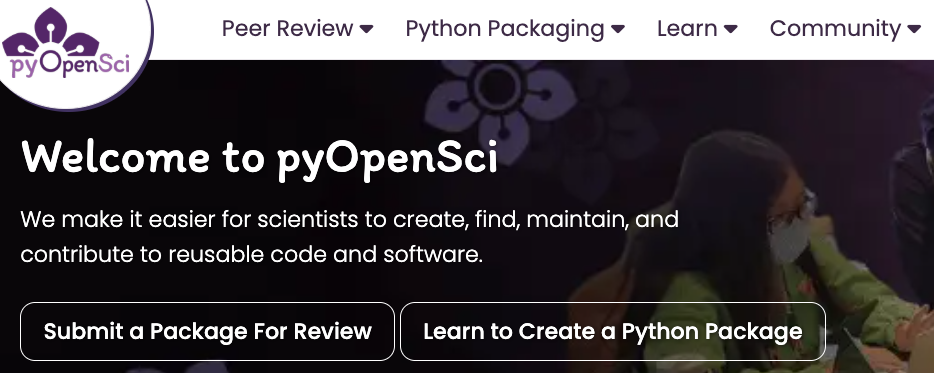

The pyOpenSci project offers both learning tools and a community of fellow scientists who share our goals of building better open, reproducible software tools that support scientific research.

The [pyOpenSci packaing guide](https://www.pyopensci.org/python-package-guide/index.html) is a great place to start, and they also have [a set of tutorials here](https://www.pyopensci.org/python-package-guide/tutorials/create-python-package.html) that use a template created using copier. You can be 0-package in just a few seconds if you want to use the simplest version of this package!